<img src = 'Image/poems.jpg' width = '2000' height = '1500'>

# Poetry Generator - Business Problem

---


A poetry generator is a sophisticated tool or program that leverages the power of algorithms and natural language processing to automatically generate poetry. It takes user-provided inputs such as keywords, themes, or prompts, and seamlessly transforms them into evocative lines of poetry. This tool is designed to be highly customizable, allowing users to personalize the poetry generation process by adjusting factors such as rhyme schemes, meter, and other literary elements to suit their specific needs. 

Whether you're a content creator seeking inspiration, an educator looking to teach the art of poetry, or a marketer or advertiser looking to add a unique and engaging touch to your campaigns, our poetry generator is the perfect solution. With its ability to generate unique and captivating poetry, it can give your campaign the edge it needs to stand out in today's crowded market.

The objective of this project is to develop a tool that enables content creators, marketers, and advertisers to generate unique and engaging poetry for use in their campaigns and marketing materials. With the growing need for creative and personalized content, a poetry generator can save time and resources for these professionals while also giving them a competitive edge in a crowded market.

# Poetry Generator - Dataset

Our project utilizes the Gutenberg Poetry corpus, a comprehensive collection of poetry comprising of approximately three million lines sourced from hundreds of books from Project Gutenberg. This corpus was expertly curated and processed by Allison Parrish, making it an ideal dataset for applications in creative computational poetic text generation. 

By accessing this dataset through the link https://github.com/aparrish/gutenberg-poetry-corpus, we aim to harness the wealth of poetry within it and use advanced algorithms and natural language processing techniques to generate new, unique, and captivating poetry. The end result of this project will be a cutting-edge poetry generator tool that will assist content creators, marketers, and advertisers in producing unique and engaging poetry for their campaigns and marketing materials, allowing them to stand out in a crowded market.

## Dataset Inspection

In [1]:
!ls Data

Gutenberg-Poetry.csv         gutenberg-poetry-v001.ndjson


In [2]:
import pandas as pd
import nltk
import tensorflow as tf

from tensorflow import keras
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from nltk.probability import FreqDist

In [3]:
df = pd.read_csv('Data/Gutenberg-Poetry.csv')
df = df[['s']]
df.rename(columns = {'s': 'Text'}, inplace = True)
df.head()

,Text
0,The Song of Hiawatha is based on the legends a...
1,"many North American Indian tribes, but especia..."
2,"Ojibway Indians of northern Michigan, Wisconsi..."
3,"They were collected by Henry Rowe Schoolcraft,..."
4,"Schoolcraft married Jane, O-bah-bahm-wawa-ge-z..."


In [4]:
df.tail()

,Text
3085112,"Far up among the hills, and, wimpling down"
3085113,"By wood and vale, its onward current keeps"
3085114,"To lonely hamlet and to stirring town,"
3085115,Cheering the wayworn traveller as it flows
3085116,When all the fields with drought are parched a...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085117 entries, 0 to 3085116
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Text    object
dtypes: object(1)
memory usage: 23.5+ MB


In [6]:
df.isna().sum()

Text    0
dtype: int64

In [7]:
df['Text'].unique()

array(['The Song of Hiawatha is based on the legends and stories of',
       'many North American Indian tribes, but especially those of the',
       'Ojibway Indians of northern Michigan, Wisconsin, and Minnesota.',
       ..., "Of his mother's chastity.'--Martin.",
       "'Neque Alexandrina beluata conchyliata tapetia.'",
       "Till all the house was gladdened with perfume.'--Martin."],
      dtype=object)

In [9]:
# Checking for duplicate text
duplicates = df[df.duplicated(subset = ['Text'], keep = False)]

if not duplicates.empty:
    print(f'There are {len(duplicates)} duplicated texts:')
    print(duplicates)
else:
    print('No duplicated texts')

There are 624676 duplicated texts:
                                                      Text
24                       "Wah-wah-taysee, little fire-fly,
26                   Little, dancing, white-fire creature,
27                       Light me with your little candle,
28                               Ere upon my bed I lay me,
29                       Ere in sleep I close my eyelids!"
...                                                    ...
3085112         Far up among the hills, and, wimpling down
3085113         By wood and vale, its onward current keeps
3085114             To lonely hamlet and to stirring town,
3085115         Cheering the wayworn traveller as it flows
3085116  When all the fields with drought are parched a...

[624676 rows x 1 columns]


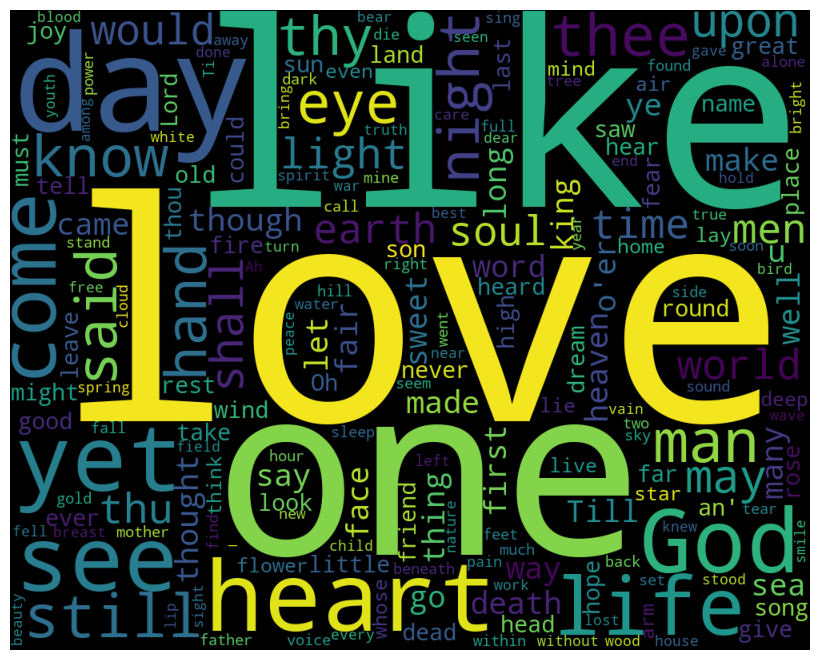

In [10]:
# WordCloud to display the most common words
# Create a string of all the text in the dataset

text = " ".join(df['Text'])

# Create a word cloud
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='Black',      
                stopwords = stopwords,
                min_font_size = 10).generate(text)


# Show the word cloud using seaborn
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Data Preprocessing - Cleaning 

In [11]:
cleaned_df = df.drop_duplicates(subset = ['Text'], keep = False)
print(cleaned_df)

                                                      Text
0        The Song of Hiawatha is based on the legends a...
1        many North American Indian tribes, but especia...
2        Ojibway Indians of northern Michigan, Wisconsi...
3        They were collected by Henry Rowe Schoolcraft,...
4        Schoolcraft married Jane, O-bah-bahm-wawa-ge-z...
...                                                    ...
3085095                   Half-open on his father's smile.
3085100                         And his face the index be,
3085101                Of his mother's chastity.'--Martin.
3085102   'Neque Alexandrina beluata conchyliata tapetia.'
3085110  Till all the house was gladdened with perfume....

[2460441 rows x 1 columns]


In [12]:
cleaned_df['Text'].value_counts().sum()

2460441

In [13]:
# Checking for missing data
df.isna().sum()

Text    0
dtype: int64

In [14]:
# Converting the text in our dataset tp lower cases to make it easier to process and analyze
cleaned_df.loc[:, 'Text'] = cleaned_df['Text'].str.lower()
cleaned_df.head()

/var/folders/ny/y4smplb93zn6dl4f36sqhd9h0000gn/T/ipykernel_15097/3930480544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'Text'] = cleaned_df['Text'].str.lower()


,Text
0,the song of hiawatha is based on the legends a...
1,"many north american indian tribes, but especia..."
2,"ojibway indians of northern michigan, wisconsi..."
3,"they were collected by henry rowe schoolcraft,..."
4,"schoolcraft married jane, o-bah-bahm-wawa-ge-z..."
